# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [3]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [6]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [7]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [9]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [10]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [11]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [12]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [13]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [14]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [15]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [16]:
realized_pnl_time=pd.DataFrame(dic).sort_index().ffill().fillna(0)
realized_pnl_time.index=pd.to_datetime(realized_pnl_time.index).round(freq='d')
realized_pnl_time=realized_pnl_time.groupby(realized_pnl_time.index).sum()

In [17]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.935036,3706.162143,0.9999,-131.886217,1521.22,1389.333783
OMUSDT,526.319895,1695.624499,0.4575,0.000000,1169.30,1169.300000
BTCUSDT,601.021649,834.049890,0.2250,3.537078,233.03,236.567078
JASMYUSDT,387.458505,438.540674,0.1183,0.000000,51.08,51.080000
SOLUSDT,281.200518,329.728001,0.0890,0.000000,48.53,48.530000
ETHUSDT,250.747339,229.561561,0.0619,0.000000,-21.19,-21.190000
TRXUSDT,76.868953,125.472888,0.0339,-10.723889,48.60,37.876111
BBUSDT,60.176053,52.012969,0.0140,-39.733101,-8.16,-47.893101
BNBUSDT,1.142121,1.171657,0.0003,-10.606040,0.03,-10.576040
PEPEUSDT,0.000004,0.000004,0.0000,-38.521986,0.00,-38.521986


In [18]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [19]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [20]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [21]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [23]:
position=pd.read_excel('Positions.xlsx',index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [24]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

quantities_tickers=list(quantities.columns)

In [25]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])

In [26]:
price_pnl.index=pd.to_datetime(price_pnl.index)
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()
for col in quantities:
    
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost.iloc[-1][col])

pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]

C:\Users\niroo\AppData\Local\Temp\ipykernel_121072\1175112299.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]


In [27]:
pnl_history['Total']-pnl_history['Total'].shift(1)

2024-09-23           NaN
2024-09-24     23.503339
2024-09-25     -7.470131
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2024-12-22    -14.543135
2024-12-23    105.666671
2024-12-24    118.985577
2024-12-25    -12.388325
2024-12-26   -165.154773
Name: Total, Length: 95, dtype: float64

In [28]:
pnl_history['Total']

2024-09-23    -378.365173
2024-09-24    -354.861834
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2024-12-22    1380.685236
2024-12-23    1486.351906
2024-12-24    1605.337484
2024-12-25    1592.949158
2024-12-26    1427.794385
Name: Total, Length: 95, dtype: float64

In [29]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [30]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [31]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [32]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


C:\Users\niroo\AppData\Local\Temp\ipykernel_121072\974280261.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  binance_data=np.log(1+binance_data.pct_change())


In [33]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [34]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [35]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<Axes: >

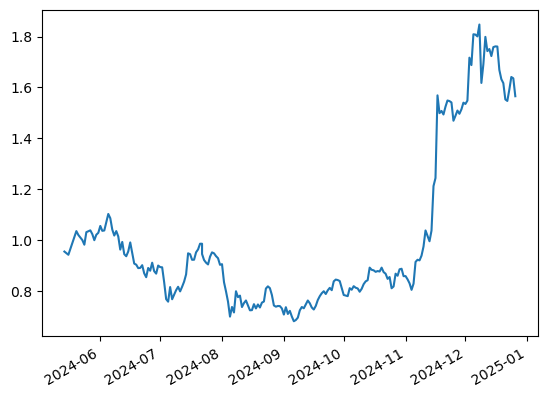

In [36]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [38]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [41]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [42]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [45]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.4167
BNBUSDT,0.2202
PEPEUSDT,0.1153
SUIUSDT,0.0987
XRPUSDT,0.0735
TRXUSDT,0.0603
AAVEUSDT,0.0090
JASMYUSDT,0.0059
ADAUSDT,0.0004
ALGOUSDT,0.0000


In [46]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.397945
BTCUSDT,0.300000
PEPEUSDT,0.080449
SUIUSDT,0.079343
BNBUSDT,0.076393
TRXUSDT,0.049434
XRPUSDT,0.016436


### Current results

In [48]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [49]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
OMUSDT,0.412708
BTCUSDT,0.392494
TRXUSDT,0.194798


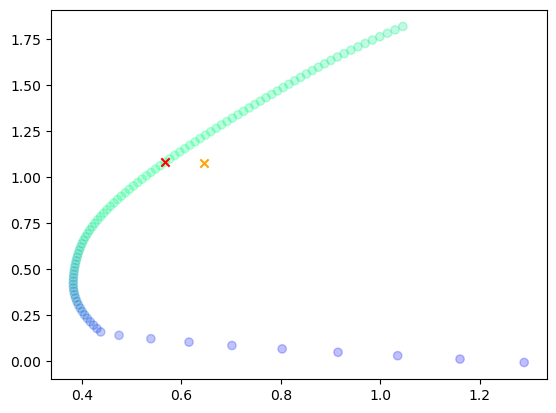

In [50]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

## Real Portfolio vs Optimal

In [52]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1695.624499,0.457515,0.412708,0.044807
BTCUSDT,834.049890,0.225044,0.392494,-0.167450
JASMYUSDT,438.540674,0.118327,0.000000,0.000000
SOLUSDT,329.728001,0.088968,0.000000,0.000000
ETHUSDT,229.561561,0.061941,0.000000,0.000000
TRXUSDT,125.472888,0.033855,0.194798,-0.160943
BBUSDT,52.012969,0.014034,0.000000,0.000000
BNBUSDT,1.171657,0.000316,0.000000,0.000000
PEPEUSDT,0.000004,0.000000,0.000000,0.000000


In [53]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1695.624499,0.457515,0.397945,0.059570
BTCUSDT,834.049890,0.225044,0.300000,-0.074956
JASMYUSDT,438.540674,0.118327,0.000000,0.000000
SOLUSDT,329.728001,0.088968,0.000000,0.000000
ETHUSDT,229.561561,0.061941,0.000000,0.000000
TRXUSDT,125.472888,0.033855,0.049434,-0.015579
BBUSDT,52.012969,0.014034,0.000000,0.000000
BNBUSDT,1.171657,0.000316,0.076393,-0.076077
PEPEUSDT,0.000004,0.000000,0.080449,-0.080449
SUIUSDT,0.000000,0.000000,0.079343,0.000000


# Risk Reward Analysis

In [55]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [56]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<Axes: >

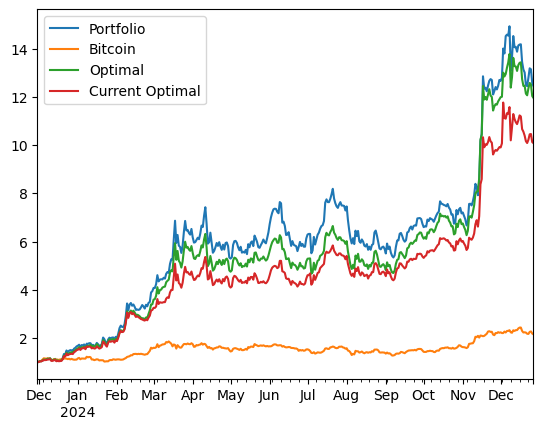

In [57]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [58]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<Axes: >

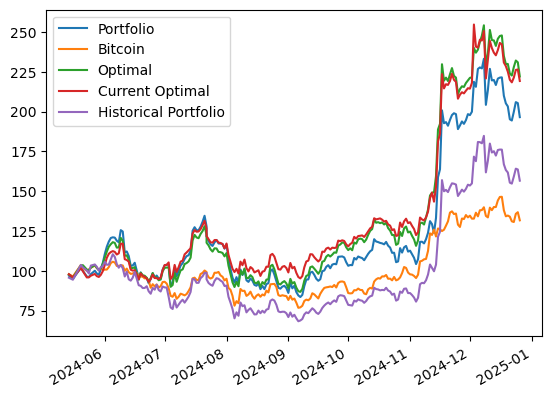

In [59]:
((1+current_perf).cumprod()*100).plot()

In [60]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-12-17,221.472359,146.438485,247.803704,242.176219,176.070219
2024-12-18,209.956891,138.019474,234.961852,230.801526,166.879687
2024-12-19,205.156342,134.189836,229.821785,228.538383,163.265422
2024-12-20,203.224373,134.662061,229.894020,225.022393,161.692923
2024-12-21,195.123225,133.953262,223.867568,219.979280,155.314800
2024-12-22,194.368968,131.022237,222.610512,218.336242,154.715129
2024-12-23,199.815598,130.602012,227.926070,221.320142,159.135218
2024-12-24,205.916182,135.706912,232.037135,226.135055,164.109079
2024-12-25,205.287548,136.756466,230.937214,226.421467,163.594790
2024-12-26,196.475501,131.658888,222.032122,219.199621,156.561732


## Volatilities

In [62]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.649677
 dtype: float64,
 0.6504800717995551)

In [63]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.645895
 dtype: float64,
 0.6458947869480616)

In [64]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.721891
Bitcoin            0.434217
Optimal            0.650480
Current Optimal    0.633788
dtype: float64

In [65]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.4564804575635222

## Risk Contribution

In [67]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.117180,0.076393,0.009237,0.026738,0.003154,0.023584
BTCUSDT,0.347225,0.300000,0.030884,0.127853,0.040104,0.087749
OMUSDT,18.911914,0.397945,0.921407,0.697643,0.596441,0.101203
PEPEUSDT,0.322750,0.080449,0.019239,0.076366,0.024382,0.051984
SUIUSDT,0.191736,0.079343,0.012935,0.050800,0.013702,0.037098
TRXUSDT,0.041034,0.049434,0.004317,0.013952,0.002730,0.011222
XRPUSDT,0.025075,0.016436,0.001981,0.006648,0.000280,0.006368


In [68]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.945635,0.412708,0.615983,0.694113,0.579379,0.114734
BTCUSDT,0.152129,0.392494,0.246976,0.162074,0.081501,0.080573
TRXUSDT,0.107398,0.194798,0.137040,0.143813,0.088884,0.054929


In [69]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,1.053995,0.46,0.697797,0.677084,0.554637,0.122447
BTCUSDT,0.089147,0.23,0.147094,0.091506,0.021566,0.069940
JASMYUSDT,0.013139,0.12,0.061363,0.119130,0.041659,0.077471
SOLUSDT,0.003165,0.09,0.042939,0.062456,0.008096,0.054360
ETHUSDT,-0.001066,0.06,0.027162,0.027838,0.002586,0.025252
TRXUSDT,0.016540,0.03,0.021450,0.011754,0.001624,0.010129
BBUSDT,-0.005242,0.01,0.002193,0.010232,0.000399,0.009834


# Value At Risk

## Historical

### Optimal Weights

In [73]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.05153946125464187, -0.0754729201157315)

### Current Weights

In [75]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.048442443116075096, -0.07291381764741467)

In [76]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [77]:
var=historical_var.iloc[row]
var

OMUSDT      -0.034123
BTCUSDT     -0.002147
JASMYUSDT   -0.006664
SOLUSDT     -0.002769
ETHUSDT     -0.001657
TRXUSDT     -0.000430
BBUSDT      -0.001246
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.049035
Name: 2024-07-22 00:00:00, dtype: float64

In [78]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.042878
BTCUSDT     -0.008055
JASMYUSDT   -0.011096
SOLUSDT     -0.006128
ETHUSDT     -0.002861
TRXUSDT     -0.000974
BBUSDT      -0.000922
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.072914
dtype: float64

## Parametric

### Optimal Weights

In [81]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.06740016851953172, -0.08638838092751748)

### Current Weights

In [83]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.06692505946531313, -0.08577942248038758)

## Multivariate

### Optimal Weights

In [86]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06098346349354741, -0.07639556578282161)

### Current Weights

In [88]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.062219502009232104, -0.08012268603560146)

In [89]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.041011
BTCUSDT     -0.005762
JASMYUSDT   -0.008159
SOLUSDT     -0.004448
ETHUSDT     -0.001824
TRXUSDT     -0.000865
BBUSDT      -0.000611
Portfolio   -0.062680
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [93]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05960555355538367, -0.07609950932221721)

### Current Weights

In [95]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06332109318338872, -0.07889171246621006)

In [96]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.039586
BTCUSDT     -0.006232
JASMYUSDT   -0.009090
SOLUSDT     -0.004109
ETHUSDT     -0.001986
TRXUSDT     -0.000843
BBUSDT      -0.000857
Portfolio   -0.062705
dtype: float64

## Student Copula

### Optimal Weights

In [99]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05968134573088675, -0.07716064876728182)

### Current Weights

In [101]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06343563966638058, -0.08196070413761565)

In [102]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.042164
BTCUSDT     -0.006670
JASMYUSDT   -0.007140
SOLUSDT     -0.004550
ETHUSDT     -0.002054
TRXUSDT     -0.000543
BBUSDT      -0.000689
Portfolio   -0.063809
dtype: float64

## Gumbel Copula

### Optimal Weights

In [105]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.11386085001750636, -0.16026034087258037)

### Current Weights

In [107]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.11209670462889511, -0.1548984254361464)

In [108]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.101520
BTCUSDT     -0.004890
JASMYUSDT   -0.004601
SOLUSDT     -0.000874
ETHUSDT      0.000079
TRXUSDT      0.000200
BBUSDT      -0.000226
Portfolio   -0.111832
dtype: float64

## Monte Carlo

### Optimal

In [111]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [112]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06844187162179192, -0.08479214754047079)

### Current Weights

In [114]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06868617211336203, -0.08630367002746105)

In [115]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.048158
BTCUSDT     -0.005497
JASMYUSDT   -0.007783
SOLUSDT     -0.003994
ETHUSDT     -0.001765
TRXUSDT     -0.000711
BBUSDT      -0.000593
Portfolio   -0.068501
dtype: float64

## VaR Violation

In [117]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.056011,-0.095380,-0.079139,-0.024634
2024-01-15,-0.056011,-0.095422,-0.078224,0.022160
2024-01-16,-0.056011,-0.094937,-0.075810,0.043504
2024-01-17,-0.056011,-0.096915,-0.083849,-0.029140
2024-01-18,-0.056011,-0.099557,-0.083256,-0.037014
...,...,...,...,...
2024-12-23,-0.086785,-0.077560,-0.076319,0.023878
2024-12-24,-0.086785,-0.077824,-0.075252,0.018037
2024-12-25,-0.086785,-0.074876,-0.069840,-0.004740
2024-12-26,-0.086785,-0.076781,-0.077211,-0.038561


In [118]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.035463,-0.084312,-0.080639,-0.017140
2024-05-29,-0.035463,-0.081724,-0.075209,-0.008795
2024-05-30,-0.035463,-0.071638,-0.067855,0.036571
2024-05-31,-0.035463,-0.072722,-0.064966,0.038871
2024-06-01,-0.035463,-0.076381,-0.066475,0.053520
...,...,...,...,...
2024-12-23,-0.114026,-0.102859,-0.109687,0.028022
2024-12-24,-0.050297,-0.074012,-0.071257,0.030531
2024-12-25,-0.050297,-0.068279,-0.072571,-0.003053
2024-12-26,-0.050725,-0.058305,-0.068095,-0.042925


<Axes: >

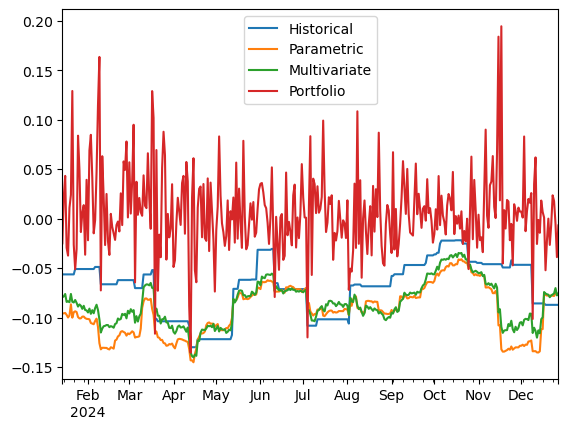

In [119]:
var_data.plot()

<Axes: >

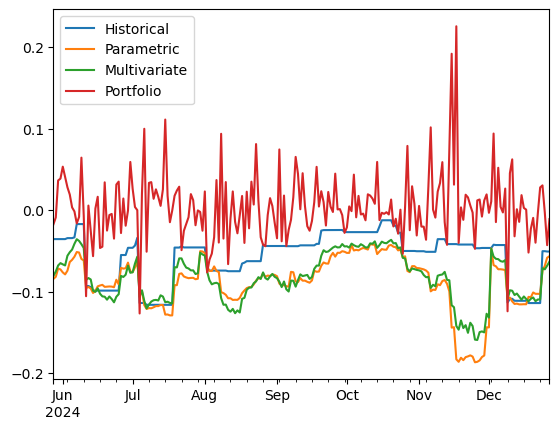

In [120]:
current_var_data.plot()

In [121]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.028653,0.011461,0.014327
Kupiec Stat,3.931072,15.654032,12.862747
P-value,0.047402,0.000076,0.000335


In [122]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.060748,0.018692,0.018692
Kupiec Stat,0.488465,5.746825,5.746825
P-value,0.484613,0.016518,0.016518


# Principal Component Analysis

## Historical PCA

In [125]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.77457355, 0.07281167, 0.05790544, 0.05047323, 0.04423611])

In [126]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.015505
ADAUSDT     0.015662
ALGOUSDT    0.017659
APTUSDT     0.016379
ARBUSDT     0.017371
              ...   
WBTCUSDT    0.009291
WLDUSDT     0.022322
XLMUSDT     0.012497
XRPUSDT     0.010843
XTZUSDT     0.016323
Name: PC1, Length: 62, dtype: float64

<Axes: >

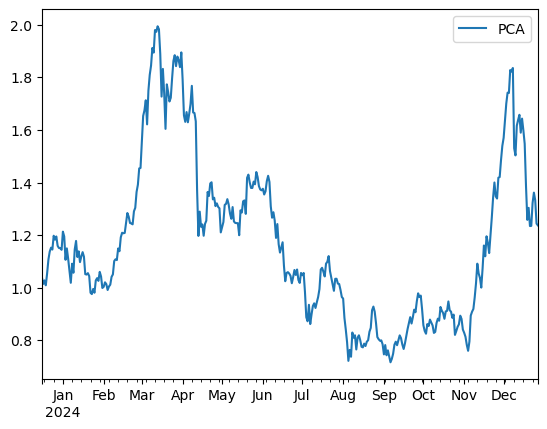

In [127]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<Axes: >

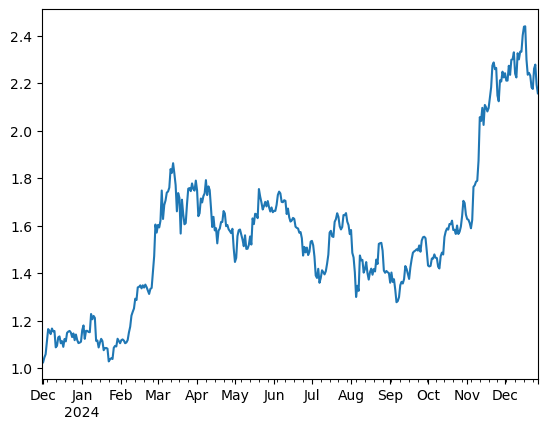

In [128]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [129]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
FLOWUSDT     0.421741
WBETHUSDT    0.424443
ETHUSDT      0.424565
ATOMUSDT     0.448950
               ...   
WLDUSDT      1.136285
BONKUSDT     1.141241
FTTUSDT      1.166615
PEPEUSDT     1.187850
OMUSDT       1.542965
Length: 63, dtype: float64

<Axes: >

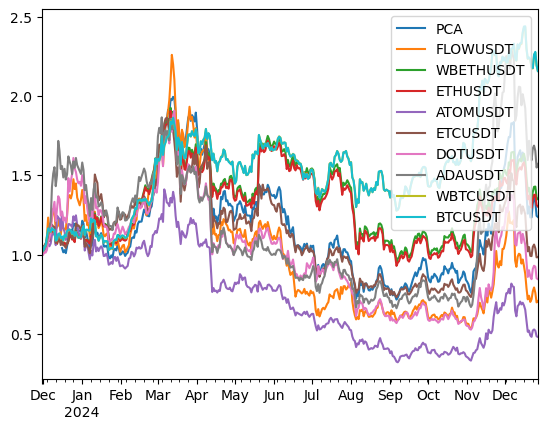

In [130]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<Axes: >

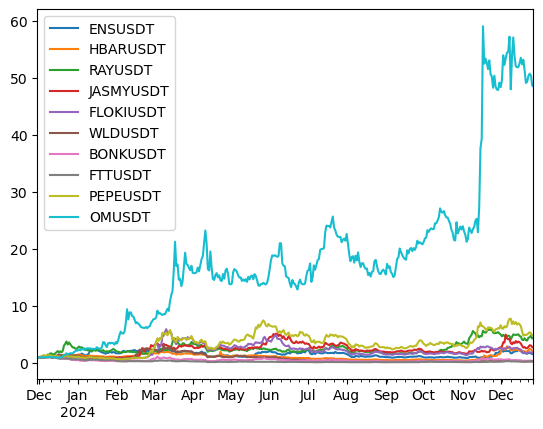

In [131]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [133]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.54427806, 0.14886504, 0.13016097, 0.10229812, 0.07439781])

In [134]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.095366
BTCUSDT      0.061047
JASMYUSDT    0.170219
SOLUSDT      0.101727
ETHUSDT      0.083516
TRXUSDT      0.050699
BBUSDT       0.214124
BNBUSDT      0.067345
PEPEUSDT     0.155957
Name: PC1, dtype: float64

<Axes: >

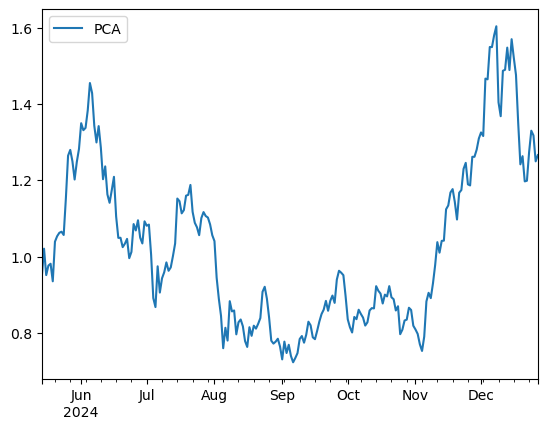

In [135]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<Axes: >

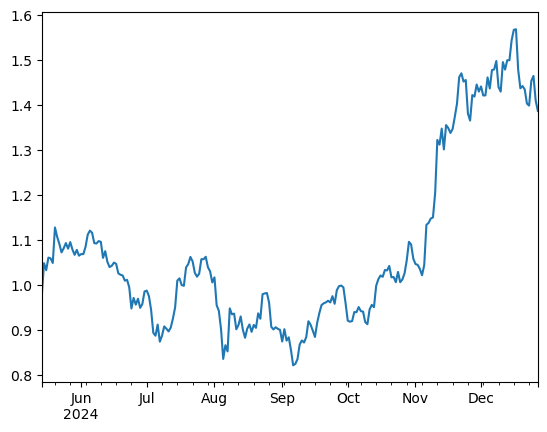

In [136]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [137]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
SOLUSDT      0.398291
ETHUSDT      0.413845
BNBUSDT      0.427251
BTCUSDT      0.446704
JASMYUSDT    0.652975
PEPEUSDT     0.718908
BBUSDT       0.744449
TRXUSDT      0.889929
OMUSDT       0.902888
dtype: float64

<Axes: >

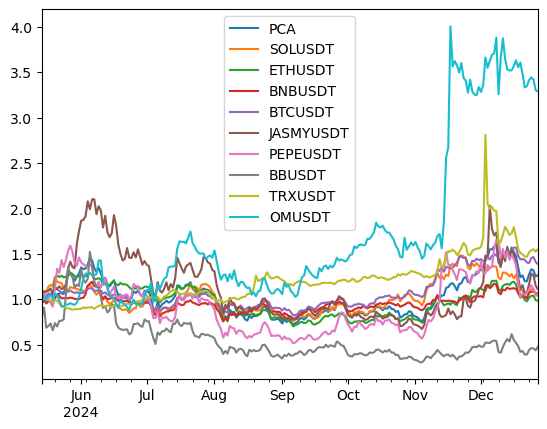

In [138]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [140]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.896463
BBUSDT       1.559425
JASMYUSDT    1.274760
SOLUSDT      1.146385
BTCUSDT      1.000000
ETHUSDT      0.960458
OMUSDT       0.876780
BNBUSDT      0.661116
TRXUSDT      0.282143
Name: BTCUSDT, dtype: float64

In [141]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

JASMYUSDT    2.194002
PEPEUSDT     1.668272
BBUSDT       1.516487
SOLUSDT      1.026839
ETHUSDT      1.025197
BTCUSDT      1.000000
TRXUSDT      0.708485
BNBUSDT      0.590170
OMUSDT       0.192573
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [143]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [144]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
ETHUSDT,0.911855
OMUSDT,0.176659
BBUSDT,0.154384
PEPEUSDT,0.080265
JASMYUSDT,0.059580
TRXUSDT,0.053367
SOLUSDT,0.044751
BTCUSDT,-0.077992
BNBUSDT,-0.135270


### Regression to PCA

In [146]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-15:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.5415933493166052

In [147]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.263537
BNBUSDT      1.133923
ETHUSDT      1.002410
PCA          1.000000
SOLUSDT      0.816193
JASMYUSDT    0.422024
PEPEUSDT     0.388463
BBUSDT       0.358568
OMUSDT       0.237260
TRXUSDT      0.195626
dtype: float64

In [148]:
reg=ex_ante_perf.copy().dropna().iloc[-15:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BNBUSDT      1.586302
ETHUSDT      1.449929
BTCUSDT      1.344317
SOLUSDT      1.067779
TRXUSDT      1.005816
PCA          1.000000
PEPEUSDT     0.740997
JASMYUSDT    0.590692
BBUSDT       0.478788
OMUSDT       0.467807
dtype: float64

### Correlation Matrix

<Axes: >

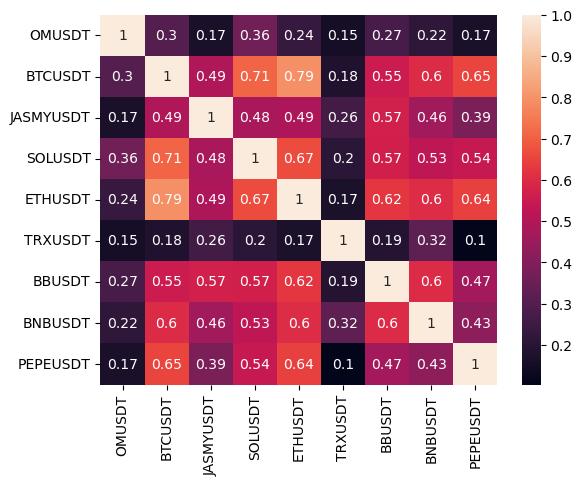

In [150]:
sns.heatmap(ex_ante_perf.corr(),annot=True)

<Axes: >

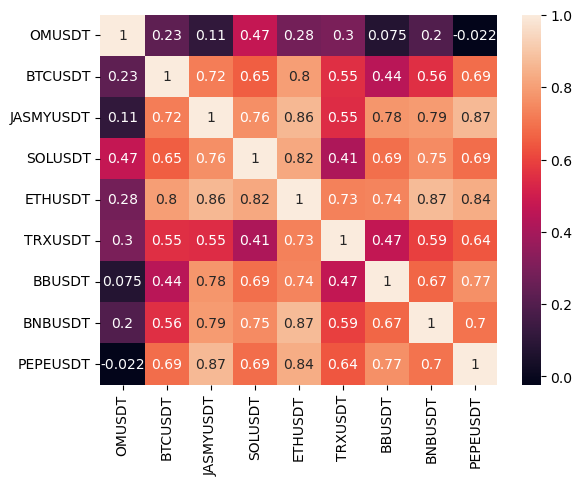

In [151]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

## Sliding window optimization

In [153]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.621968,0.000000,0.000000,0.000000,0.000000,0.000000,0.378032
2024-06-10,0.625939,0.000000,0.150852,0.000000,0.000000,0.223209,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.182528,0.000000,0.000000,0.000000,0.000000,0.817472,0.000000,0.000000,0.000000
2024-07-22,0.133242,0.414562,0.000000,0.112009,0.000000,0.340186,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926694,0.000000,0.073306,0.000000
2024-09-02,0.435138,0.000000,0.000000,0.000000,0.000000,0.564862,0.000000,0.000000,0.000000
2024-09-16,0.287440,0.000000,0.000000,0.000000,0.000000,0.000000,0.712560,0.000000,0.000000
2024-09-30,0.176666,0.000000,0.000000,0.000000,0.165949,0.527049,0.000000,0.000000,0.130336


In [154]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-05-21,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.687225,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
2024-06-20,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
2024-07-20,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.728768,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
2024-08-19,0.904427,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.095573,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
2024-09-18,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.139296,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
2024-10-18,0.000000,0.000000,0.0,0.005266,0.0,0.0,0.0,0.0,0.0,0.0,...,0.309536,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
2024-11-17,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004057,0.0,0.0,0.0,0.0,0.000000,0.0,0.005621,0.000000,0.0
2024-12-17,0.217573,0.022666,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.064141,0.0,0.000000,0.234455,0.0
2024-12-27,0.000000,0.000002,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
